In [180]:
import gensim
from gensim import corpora, models
import langdetect
import unicodedata
from langdetect import detect_langs
from nltk.stem.porter import PorterStemmer
import sklearn.feature_extraction.text as text
from sklearn import decomposition
from stop_words import get_stop_words
import os
import numpy as np

In [181]:
#Técnica de factorización de la matriz no negativa (NMF) 
CORPUS_PATH = os.path.join('data', 'output/es')
print(CORPUS_PATH)
filenames = sorted([os.path.join(CORPUS_PATH, fn) for fn in os.listdir(CORPUS_PATH)])

data\output/es


In [182]:
# Archivos están ubicados en data in data/output
len(filenames)
filenames[:5]

['data\\output/es\\1and1.es.txt',
 'data\\output/es\\1arte.com.txt',
 'data\\output/es\\1mbup.com.txt',
 'data\\output/es\\2son2.com.txt',
 'data\\output/es\\2tmoto.com.txt']

In [183]:
# Detectamos el idioma
with open(filenames[1]) as f:
    fdata = [line.rstrip() for line in f]
    g = fdata[0]
    lang = detect_langs(g.decode('utf-8'))
    
print(lang)

[es:0.999995908617]


In [184]:
#Por analogía con LDA, utilizaremos NMF para obtener una matriz de documentos relacionados con el
#tema (temas aquí también se conocen como "componentes") y una lista de los mejores palabras para cada tema.
# creamos las lista de stopwords
l = str(lang[0])
lang = l.rstrip().split(":")
lang_stop = get_stop_words(lang[0])

# Añadimos stopwords a nuestra lista generica separada por espacios
more_stopwords = ['nav', '01icon', 'icon','online','mejor','www','com','http','encontrar','información','federación','encuentra',
                  'oferta','española','español','españa','barato','gratis','tienda','gran','página','comprar','precio','web','toda']
#lang_stop += more_stopwords.split(",")
for m in more_stopwords:
    lang_stop.append(m)
    
print(lang_stop[::-10])

vectorizer = text.CountVectorizer(input='filename', stop_words=lang_stop, max_df = 5)
dtm = vectorizer.fit_transform(filenames).toarray()# lista de documentos ordenada
vocab = np.array(vectorizer.get_feature_names())

dtm.shape

['toda', 'espa\xc3\xb1ol', 'mejor', 'gran', 'informaci\xc3\xb3n', 'toda', 'espa\xc3\xb1ol', 'mejor', 'gran', 'informaci\xc3\xb3n', 'toda', 'espa\xc3\xb1ol', 'mejor', 'gran', 'informaci\xc3\xb3n', 'toda', 'espa\xc3\xb1ol', 'mejor', 'gran', 'informaci\xc3\xb3n', 'toda', 'espa\xc3\xb1ol', 'mejor', 'gran', 'informaci\xc3\xb3n', 'toda', 'espa\xc3\xb1ol', 'mejor', 'gran', 'informaci\xc3\xb3n', 'toda', 'espa\xc3\xb1ol', 'mejor', 'gran', 'informaci\xc3\xb3n', 'toda', 'espa\xc3\xb1ol', 'mejor', 'barato', 'com', 'tienda', 'encontrar', 'comprar', 'encuentra', 'madrid', 'gratis', 'http', 'web', 'espa\xc3\xb1ola', 'online', 'gran', 'informaci\xc3\xb3n', 'toda', 'espa\xc3\xb1a', 'www', 'mejor', 'online', 'gran', 'informaci\xc3\xb3n', 'toda', 'espa\xc3\xb1a', 'www', 'comprar', 'encuentra', 'madrid', 'gratis', 'http', 'web', 'espa\xc3\xb1ola', 'online', 'gran', 'informaci\xc3\xb3n', 'toda', 'espa\xc3\xb1a', 'www', 'comprar', 'encuentra', 'madrid', 'barato', 'barato', 'web', 'espa\xc3\xb1ola', 'online'

(722L, 6433L)

In [185]:
num_topics = 25
num_top_words = 25
clf = decomposition.NMF(n_components=num_topics, random_state=1)

# obtenemos los topic
doctopic = clf.fit_transform(dtm)

# Palabras asociadas a temas
# Hacemos steaming
p_stemmer = PorterStemmer()
topic_words = []
for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([p_stemmer.stem(vocab[i].encode('ascii','ignore')) for i in word_idx])
    
print(topic_words[:5])

[['objetivo', u'man', 'momento', 'militar', 'do', 'visual', 'len', 'chef', 'canta', u'president', 'soraya', 'leklein', 'prisin', 'crtico', 'snchez', 'partido', 'moreno', u'demanda', 'comenz', 'eurovisin', 'castilla', u'tra', u'militant', 'cristina', u'call'], ['costa', 'max', 'remax', 're', 'piso', u'properti', u'local', 'almera', 'chalet', 'marbella', 'blanca', 'franquicia', u'industri', u'leas', 'land', u'commerci', 'propiedad', u'detach', 'apartamento', u'estat', u'santand', u'inmobiliaria', u'propiedad', 'valladolid', 'mlaga'], ['papel', 'tinta', 'laser', 'lser', u'formulario', 'impresora', u'cartucho', u'impresora', u'negocio', 'producto', 'tecnologia', u'maquina', u'perforadora', u'imprerora', u'toner', u'clip', 'fax', 'reciclado', 'toner', u'seleccion', 'perforadora', 'tner', u'vike', 'laserjet', u'carpeta'], [u'boda', 'boda', u'invitacion', u'banquet', 'musica', u'recuerdo', 'organizacin', u'cater', 'mesa', 'decoracion', 'miguel', 'aventura', 'oro', u'lui', u'anillo', 'rico', u

In [186]:
doctopic = (doctopic / (np.sum(doctopic, axis=1, keepdims=True)))

C:\Users\Maite\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


In [187]:
#promedio de las acciones de temas asociados con el mismo documento
doc_names = []

for fn in filenames:
    basename = os.path.basename(fn)
    name, ext = os.path.splitext(basename)
    name = name.rstrip('0123456789')
    doc_names.append(name) 

# Convertir en matriz para que podamos usar las funciones NumPy 
doc_names = np.asarray(doc_names)
doctopic_orig = doctopic.copy()

#  Sección de preprocesamiento
num_groups = len(set(doc_names))
doctopic_grouped = np.zeros((num_groups, num_topics))#721,20

for i, name in enumerate(sorted(set(doc_names))):
    doctopic_grouped[i, :] = np.mean(doctopic[doc_names == name, :], axis=0) 

doctopic = doctopic_grouped
print(doctopic)

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   2.37654882e-03 ...,   9.97623451e-01
    0.00000000e+00   0.00000000e+00]
 [  3.56706636e-04   1.57430222e-02   0.00000000e+00 ...,   3.62028813e-02
    4.30082893e-03   3.86734313e-02]
 ..., 
 [  4.83356679e-02   0.00000000e+00   0.00000000e+00 ...,   4.29846213e-01
    0.00000000e+00   1.11795347e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    1.61411918e-01   0.00000000e+00]
 [  8.67368248e-01   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


In [188]:
# Vamos a identificar los temas más importantes para cada texto en el corpus.
# Este procedimiento no difiere esencialmente del procedimiento de identificación
# de las palabras más frecuentes en cada texto.
docs = sorted(set(doc_names))
print("Top NMF topics in...")

# Tema en los que clasifica cada doc del corpus en orden
for i in range(len(doctopic)):
    top_topics = np.argsort(doctopic[i,:])[::-1][0:]
    #top_topics = np.argsort(doctopic[i,:])[::-1][0:3]
    top_topics_str = ' '.join(str(t) for t in top_topics)
    print("{}: {}".format(docs[i], top_topics_str))

Top NMF topics in...
1and1.es: 9 15 13 5 24 10 1 2 3 4 6 7 8 12 11 23 14 16 17 18 19 20 21 22 0
1arte.com: 22 2 24 11 1 3 4 5 6 7 8 9 10 12 23 13 14 15 16 17 18 19 20 21 0
1mbup.com: 21 15 5 7 24 22 1 9 23 6 12 0 18 13 14 11 10 16 8 17 19 4 3 2 20
2son2.com: 8 4 3 17 23 12 21 14 1 19 2 9 13 18 7 5 6 24 10 11 15 16 20 22 0
2tmoto.com: 17 21 12 22 18 10 23 4 19 14 16 3 2 7 1 5 6 24 8 9 11 13 15 20 0
2y4t.com: 10 16 8 1 13 23 15 24 9 2 3 4 5 6 7 12 11 14 17 18 19 20 21 22 0
42195.es: 23 0 16 11 10 1 2 3 4 5 6 7 8 9 24 13 14 15 17 18 19 20 21 22 12
7heroes.es: 15 24 21 11 7 23 22 13 5 8 1 2 3 4 6 12 9 10 14 16 17 18 19 20 0
888.com: 24 21 23 2 15 4 11 0 13 16 7 1 22 3 20 5 6 8 17 9 10 19 18 14 12
888.es: 24 11 1 2 3 4 5 6 7 8 9 10 12 23 13 14 15 16 17 18 19 20 21 22 0
999gag.com: 13 24 11 1 2 3 4 5 6 7 8 9 10 12 23 14 15 16 17 18 19 20 21 22 0
a-cero.com: 0 14 17 10 1 2 3 4 5 6 7 8 9 24 11 23 13 15 16 18 19 20 21 22 12
a3m.eu: 2 7 20 8 13 5 24 10 1 3 4 6 9 12 11 23 14 15 16 17 18 19 21 22 

In [189]:
# Tenemos listas de palabras (topic_words) que más se relacionan con los componentes.
for t in range(len(topic_words)):
    print("Topic {}: {}".format(t,' '.join(topic_words[t][:15]).encode('ascii','ignore')))

Topic 0: objetivo man momento militar do visual len chef canta president soraya leklein prisin crtico snchez
Topic 1: costa max remax re piso properti local almera chalet marbella blanca franquicia industri leas land
Topic 2: papel tinta laser lser formulario impresora cartucho impresora negocio producto tecnologia maquina perforadora imprerora toner
Topic 3: boda boda invitacion banquet musica recuerdo organizacin cater mesa decoracion miguel aventura oro lui anillo
Topic 4: uefa cup futsal sala lnf futbol fantasi copa campeon arbitro entrenador leagu footbal jugador train
Topic 5: storag offic shelv file pedest mobil system high rack card bisley furnitur cupboard steel design
Topic 6: blue bluenumbers_f bluecoffe arrow crdito rpido credito prstamo solicita pasta box transferencia whitelogin whiteclassicphon whitemoney
Topic 7: misc navig app homephotoicon officeicon multifuncin businessscann largeformatprint portablesmartglass 01 asistencia impresora formato mobil desktop
Topic 8: cu

In [208]:
# Hacemos join del dominio, el identificador del topic y de la bolsa de palabras 
docs = sorted(set(doc_names))
#print("Dominios con Topics...")

# Tema en los que clasifica cada doc del corpus en orden
for t in range(len(topic_words)):
    for i in range(len(doctopic)):
        top_topics = np.argsort(doctopic[i,:])[::-1][0:1]
        top_topics_str = ' '.join(str(t) for t in top_topics)
        if t in np.argsort(doctopic[i,:])[::-1][0:1]:
            print("{}|{}|{}".format(docs[i], top_topics_str,' '.join(topic_words[t][:15]).encode('ascii','ignore') ))
            filename ="data/output/" + "outputFull" + ".txt"
            if not os.path.exists(os.path.dirname(filename)):
                os.makedirs(os.path.dirname(filename))
            with open(filename, 'a+') as myfile:
                myfile.write("{}|{}|{}".format(docs[i], top_topics_str,' '.join(topic_words[t][:25]).encode('ascii','ignore') )+'\n')

a-cero.com|0|objetivo man momento militar do visual len chef canta president soraya leklein prisin crtico snchez
adaec.org|0|objetivo man momento militar do visual len chef canta president soraya leklein prisin crtico snchez
amena.com|0|objetivo man momento militar do visual len chef canta president soraya leklein prisin crtico snchez
appolo.es|0|objetivo man momento militar do visual len chef canta president soraya leklein prisin crtico snchez
arpem.com|0|objetivo man momento militar do visual len chef canta president soraya leklein prisin crtico snchez
arqa.com|0|objetivo man momento militar do visual len chef canta president soraya leklein prisin crtico snchez
arquia.es|0|objetivo man momento militar do visual len chef canta president soraya leklein prisin crtico snchez
arriva.es|0|objetivo man momento militar do visual len chef canta president soraya leklein prisin crtico snchez
aupair.es|0|objetivo man momento militar do visual len chef canta president soraya leklein prisin crtico

In [197]:
# Temas distintivos
cate1_indices, cate2_indices = [], []

for index, fn in enumerate(sorted(set(doc_names))):
    if "juego" in fn:
        cate1_indices.append(index)
    elif "salud" in fn:
        cate2_indices.append(index)

cate1_avg = np.mean(doctopic[cate1_indices, :], axis=0)
cate2_avg = np.mean(doctopic[cate2_indices, :], axis=0)
keyness = np.abs(cate1_avg - cate2_avg)
ranking = np.argsort(keyness)[::-1]  # from highest to lowest; [::-1] reverses order in Python sequences

# distinctive topics:
ranking[:10]

C:\Users\Maite\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in absolute


array([24, 11,  1,  2,  3,  4,  5,  6,  7,  8], dtype=int64)

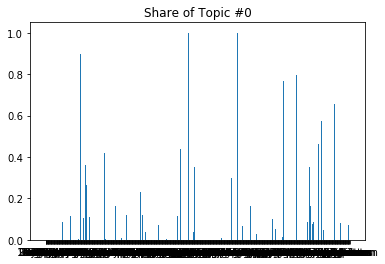

In [198]:
%matplotlib inline
import matplotlib.pyplot as plt

N, K = doctopic.shape
ind = np.arange(N)  # points on the x-axis

width = 0.5

plt.bar(ind, doctopic[:,0], width=width)
plt.xticks(ind + width/10, docs)  # put labels in the center

plt.title('Share of Topic #0')